In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_style("ticks")
sns.set_palette('muted')

In [3]:
data = pd.read_csv('CAX_MortgageModeling_Train.csv')
dfx = pd.DataFrame(data)

In [4]:
dfx['RESULT'].value_counts()

FUNDED        36023
NOT FUNDED     9619
Name: RESULT, dtype: int64

In [5]:
#Cleaning Function
def clean_data(df):
    
    df.set_index('Unique_ID', inplace=True)
    df.drop(['MORTGAGE NUMBER'], axis=1, inplace=True)
    df['LTV'] = df['MORTGAGE AMOUNT'] / df['PROPERTY VALUE'] * 100
    
    df['AMORTIZATION'] = df['AMORTIZATION']
    
    df_temp = df['FSA'].str.split('', n=3, expand=True)
    df_temp[2] = df_temp[2].astype(int)
    
    df_temp['URBAN'] = np.where(df_temp[2] > 0, 1, 0)
    
    df_temp.drop([0, 2, 3], axis=1, inplace=True)
    df_temp.rename(columns={1: 'TERRITORY'}, inplace=True)
    
    df = pd.concat([df, df_temp], axis=1)
    df.drop(['FSA'], axis=1, inplace=True)
    
    return df

df = clean_data(dfx)

In [6]:
from scipy.stats import zscore

z_thresh = 4

def remove_outliers(df):
    
    df['mortgage_amt_z'] = zscore(df['MORTGAGE AMOUNT'])
    df['property_val_z'] = zscore(df['PROPERTY VALUE'])
    
    df = df[(df['property_val_z'] <= z_thresh) & (df['mortgage_amt_z'] <= z_thresh)]
    df = df.drop(['mortgage_amt_z', 'property_val_z'], axis=1)
    
    df = df[(df['RATE'] < 7.5) & (df['RATE'] > 3.5)]
    
    return df

df = remove_outliers(df)
df['RESULT'].value_counts()

FUNDED        34015
NOT FUNDED     9214
Name: RESULT, dtype: int64

In [7]:
# Some Credit Scores are Zero - May be Encoding something (No Credit?)
df[df['CREDIT SCORE'] == 0].groupby('RESULT')['CREDIT SCORE'].count()

RESULT
FUNDED        852
NOT FUNDED    298
Name: CREDIT SCORE, dtype: int64

In [8]:
# Check degree of Imbalance
df['RESULT'].value_counts()

FUNDED        34015
NOT FUNDED     9214
Name: RESULT, dtype: int64

In [9]:
# Group by Result & Purpose
df.groupby(['RESULT', 'MORTGAGE PURPOSE']).mean()

PROPERTY VALUE  MORTGAGE PAYMENT         GDS  \
RESULT     MORTGAGE PURPOSE                                                 
FUNDED     Purchase           532559.217465       2251.956971  415.285179   
           Refinance          533797.156335       2159.803136  102.194024   
NOT FUNDED Purchase           614743.634548       2582.621068   26.456518   
           Refinance          597063.940092       2478.666667   29.901008   

                                   LTV         TDS  AMORTIZATION  \
RESULT     MORTGAGE PURPOSE                                        
FUNDED     Purchase          75.861329  880.617839    357.010124   
           Refinance         73.422903  110.591146    353.207096   
NOT FUNDED Purchase          75.346591   38.530871    356.255617   
           Refinance         74.202929   40.008078    353.767281   

                             MORTGAGE AMOUNT      RATE       TERM  \
RESULT     MORTGAGE PURPOSE                                         
FUNDED     Purchase            402471.586456  4.565387  14.469099   
           Refinance           381321.925153  4.771660  16.163046   
NOT FUNDED Purchase            455470.291980  4.621068  14.451822   
           Refinance           426584.145636  4.883833  15.216590   

                                    INCOME  INCOME TYPE  CREDIT SCORE  \
RESULT     MORTGAGE PURPOSE                                             
FUNDED     Purchase          129085.266821     5.359365    683.245571   
           Refinance         107176.533121     5.105707    632.509667   
NOT FUNDED Purchase          133754.618073     5.272841    686.962307   
           Refinance         115108.678955     5.286674    634.476190   

                                URBAN  
RESULT     MORTGAGE PURPOSE            
FUNDED     Purchase          0.956391  
           Refinance         0.949904  
NOT FUNDED Purchase          0.954818  
           Refinance         0.936060

In [10]:
# Group by Result & Purpose
df.groupby(['RATE', 'RESULT'])['RESULT'].count()

RATE  RESULT    
3.75  FUNDED        1003
      NOT FUNDED     230
4.00  FUNDED        5892
      NOT FUNDED    1157
4.25  FUNDED        5061
      NOT FUNDED    1303
4.50  FUNDED        5850
      NOT FUNDED    1466
4.75  FUNDED        3780
      NOT FUNDED    1037
5.00  FUNDED        7333
      NOT FUNDED    2017
5.25  FUNDED        1389
      NOT FUNDED     538
5.50  FUNDED        1926
      NOT FUNDED     697
5.75  FUNDED         333
      NOT FUNDED     135
6.00  FUNDED        1268
      NOT FUNDED     528
6.25  FUNDED          44
      NOT FUNDED      32
6.50  FUNDED          42
      NOT FUNDED      18
6.75  FUNDED           5
      NOT FUNDED       1
7.00  FUNDED          89
      NOT FUNDED      55
Name: RESULT, dtype: int64

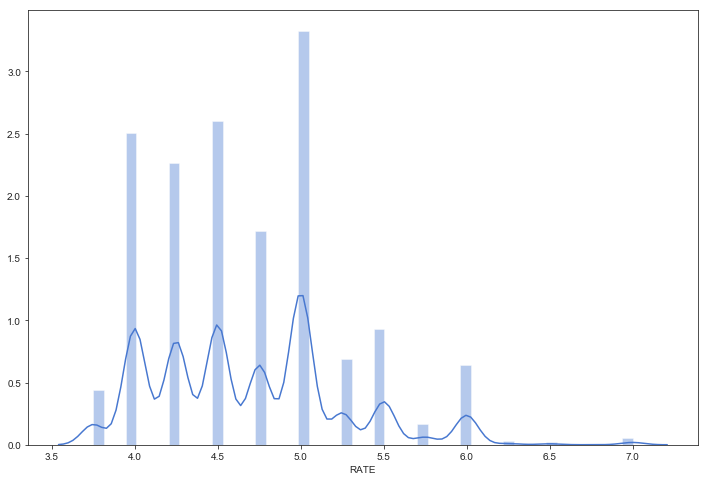

In [11]:
plt.figure(figsize=(12,8))
sns.distplot(df['RATE']);

## EDA

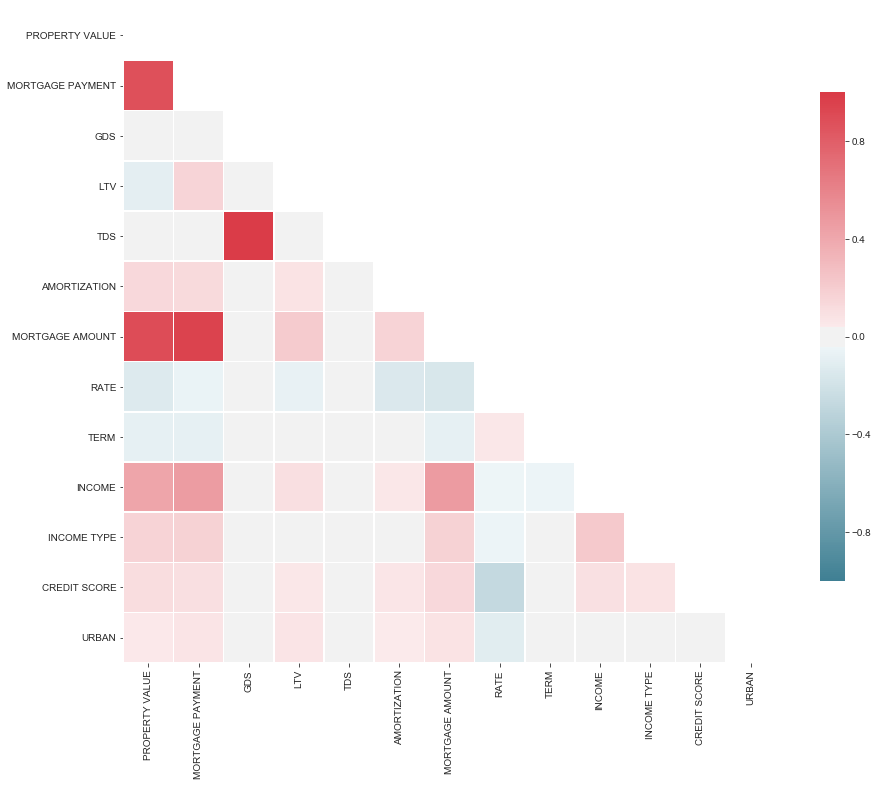

In [12]:
corr = df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .75});

In [13]:
df.describe()

,PROPERTY VALUE,MORTGAGE PAYMENT,GDS,LTV,TDS,AMORTIZATION,MORTGAGE AMOUNT,RATE,TERM,INCOME,INCOME TYPE,CREDIT SCORE,URBAN
count,4.322900e+04,43229.000000,4.322900e+04,43229.000000,4.322900e+04,43229.000000,4.322900e+04,43229.000000,43229.000000,4.322900e+04,43229.000000,43229.000000,43229.000000
mean,5.483774e+05,2277.827037,2.238150e+02,74.764849,4.332106e+02,355.225427,4.029242e+05,4.680729,15.147332,1.202062e+05,5.254274,660.049851,0.951537
std,3.213872e+05,1304.173727,3.353617e+04,22.184840,6.602764e+04,18.151435,2.358890e+05,0.568327,7.286854,1.011637e+05,3.282210,134.107769,0.214745
min,1.400000e+04,141.000000,-3.704000e+01,4.249909,-1.070000e+01,60.000000,1.500000e+04,3.750000,6.000000,1.000000e+03,-1.000000,0.000000,0.000000
25%,3.330000e+05,1389.000000,1.947000e+01,66.666667,3.285000e+01,360.000000,2.410000e+05,4.250000,12.000000,6.700000e+04,2.000000,620.000000,1.000000
50%,4.650000e+05,1999.000000,2.914000e+01,75.000000,3.839000e+01,360.000000,3.500000e+05,4.500000,12.000000,9.500000e+04,6.000000,674.000000,1.000000
75%,6.600000e+05,2807.000000,3.600000e+01,80.000000,4.224000e+01,360.000000,5.000000e+05,5.000000,12.000000,1.410000e+05,8.000000,734.000000,1.000000
max,2.323000e+06,11322.000000,6.872300e+06,2285.714286,1.346256e+07,480.000000,1.630000e+06,7.000000,60.000000,2.400000e+06,20.000000,899.000000,1.000000


In [14]:
df.corr()

,PROPERTY VALUE,MORTGAGE PAYMENT,GDS,LTV,TDS,AMORTIZATION,MORTGAGE AMOUNT,RATE,TERM,INCOME,INCOME TYPE,CREDIT SCORE,URBAN
PROPERTY VALUE,1.000000,0.876847,0.017893,-0.099152,0.017662,0.135266,0.902501,-0.127484,-0.078398,0.418921,0.168282,0.113979,0.053809
MORTGAGE PAYMENT,0.876847,1.000000,0.011065,0.158281,0.010761,0.127267,0.948432,-0.058612,-0.082562,0.462577,0.172057,0.104571,0.072876
GDS,0.017893,0.011065,1.000000,-0.005253,0.990829,0.001552,0.008134,0.003861,-0.002530,-0.006127,0.001943,0.001114,0.001317
LTV,-0.099152,0.158281,-0.005253,1.000000,-0.005650,0.083730,0.205446,-0.073265,0.002923,0.101621,0.009191,0.062302,0.070519
TDS,0.017662,0.010761,0.990829,-0.005650,1.000000,0.001585,0.007825,0.004881,-0.002589,-0.005546,0.002120,0.001695,0.001346
AMORTIZATION,0.135266,0.127267,0.001552,0.083730,0.001585,1.000000,0.167223,-0.142626,-0.037119,0.059423,0.025993,0.067372,0.044613
MORTGAGE AMOUNT,0.902501,0.948432,0.008134,0.205446,0.007825,0.167223,1.000000,-0.160934,-0.080051,0.475669,0.172414,0.137169,0.083346
RATE,-0.127484,-0.058612,0.003861,-0.073265,0.004881,-0.142626,-0.160934,1.000000,0.055277,-0.043703,-0.047808,-0.266963,-0.111713
TERM,-0.078398,-0.082562,-0.002530,0.002923,-0.002589,-0.037119,-0.080051,0.055277,1.000000,-0.047160,0.006796,-0.017121,-0.026172
INCOME,0.418921,0.462577,-0.006127,0.101621,-0.005546,0.059423,0.475669,-0.043703,-0.047160,1.000000,0.219381,0.096749,0.027132


In [15]:
#sns.pairplot(df);

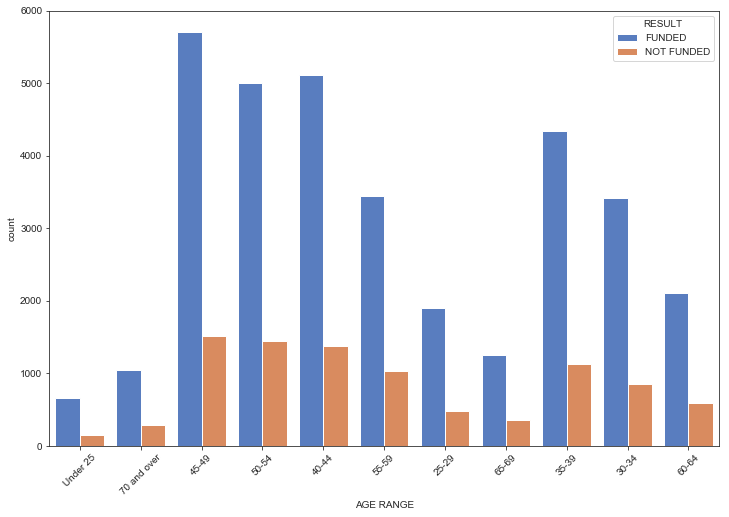

In [16]:
plt.figure(figsize=(12,8))
sns.countplot(df['AGE RANGE'], hue=df['RESULT'])
plt.xticks(rotation=45);

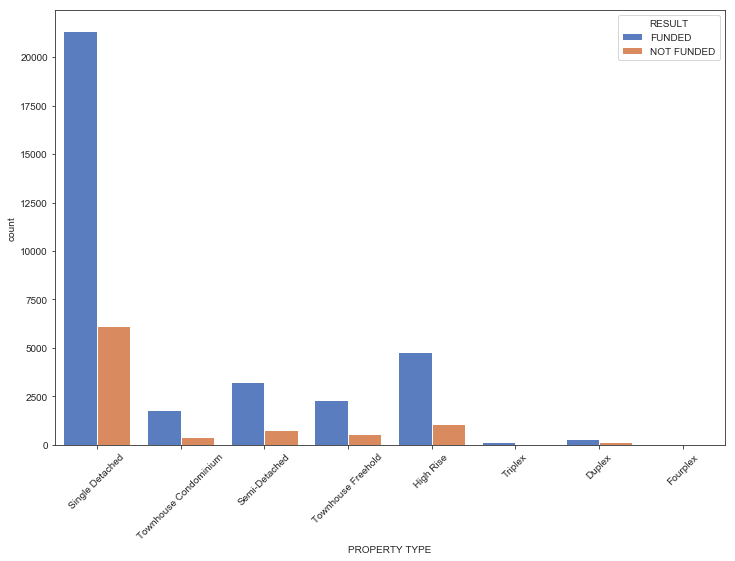

In [17]:
plt.figure(figsize=(12,8))
sns.countplot(df['PROPERTY TYPE'], hue=df['RESULT'])
plt.xticks(rotation=45);

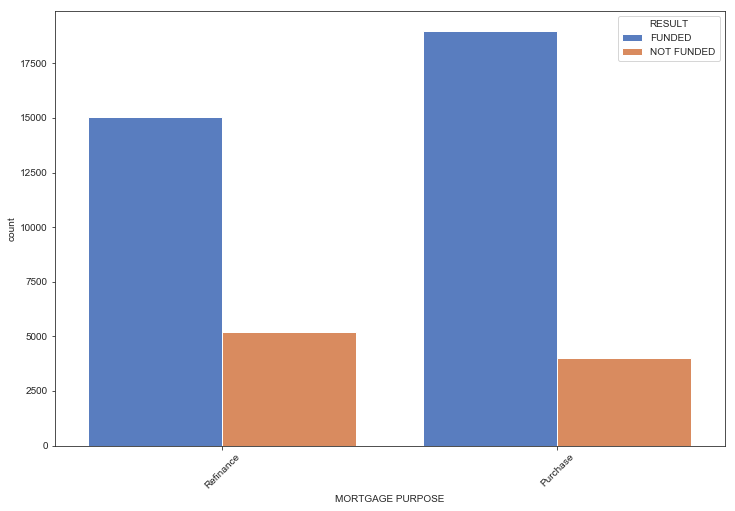

In [18]:
plt.figure(figsize=(12,8))
sns.countplot(df['MORTGAGE PURPOSE'], hue=df['RESULT'])
plt.xticks(rotation=45);

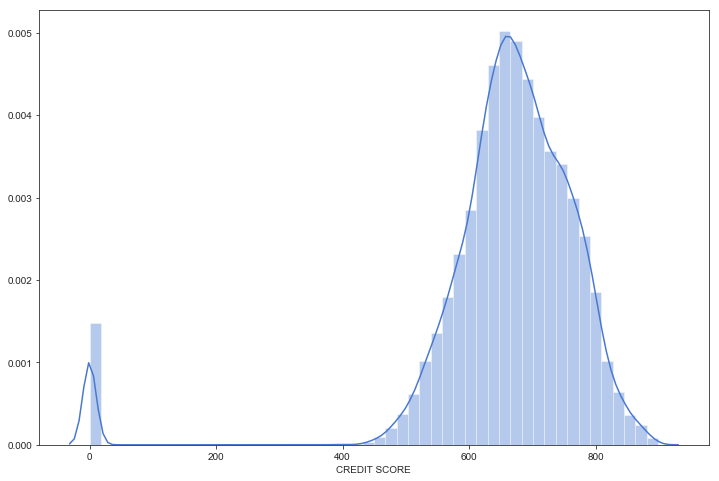

In [19]:
plt.figure(figsize=(12,8))
sns.distplot(df['CREDIT SCORE']);

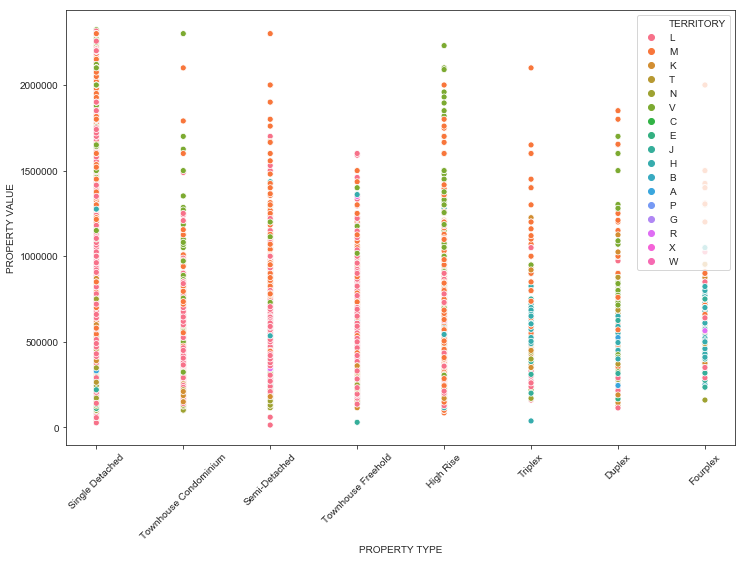

In [20]:
plt.figure(figsize=(12,8))
sns.scatterplot(x="PROPERTY TYPE", y="PROPERTY VALUE", 
                hue = 'TERRITORY',
                data=df)
plt.xticks(rotation=45);

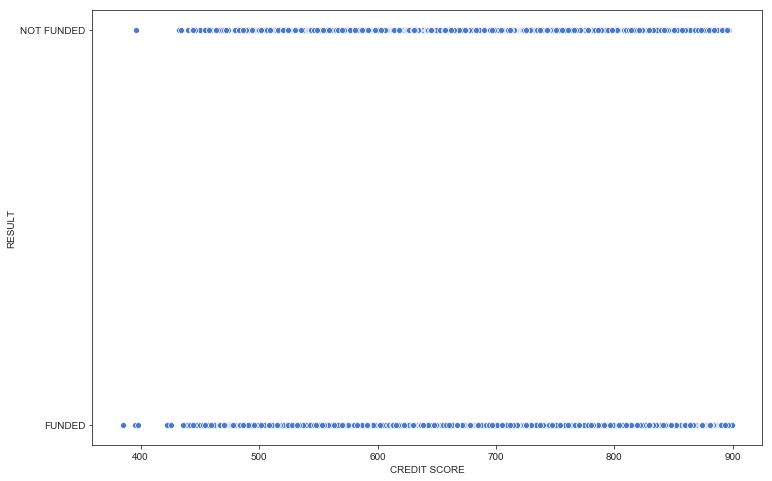

In [21]:
plt.figure(figsize=(12,8))

data = df
x1 = df[df['CREDIT SCORE'] > 0]['CREDIT SCORE']
y1 = df[df['CREDIT SCORE'] > 0]['RESULT']


ax1 = sns.scatterplot(x=x1, y=y1,
                data=data);

In [22]:
df.columns

Index(['PROPERTY VALUE', 'MORTGAGE PAYMENT', 'GDS', 'LTV', 'TDS',
       'AMORTIZATION', 'MORTGAGE AMOUNT', 'RATE', 'MORTGAGE PURPOSE',
       'PAYMENT FREQUENCY', 'PROPERTY TYPE', 'TERM', 'AGE RANGE', 'GENDER',
       'INCOME', 'INCOME TYPE', 'NAICS CODE', 'CREDIT SCORE', 'RESULT',
       'TERRITORY', 'URBAN'],
      dtype='object')

## ENCODING & FEATURE ENGINEERING

In [23]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
 def add_features(df):
        
    constant = ((np.pmt(df['RATE'] / 100 / 12, df['AMORTIZATION'] / 12, -df['MORTGAGE AMOUNT'])) / df['MORTGAGE AMOUNT']) * 100 * 12
    df['ZERO SCORE'] = np.where(df['CREDIT SCORE'] == 0, 1, 0)
    df['RATIO'] = (constant * df['MORTGAGE AMOUNT']) / df['INCOME']
    print(1)
    
    df['RATE_X_CREDIT_SCORE'] = df['RATE'] * df['CREDIT SCORE']
    df['RATE_X_LTV'] = df['RATE'] * df['LTV']
    df['URBAN_X_PROPERTY_VAL'] = df['URBAN'] * df['PROPERTY VALUE']
    df['PURPOSE_X_PROPERTY_VAL'] = df['MORTGAGE PURPOSE'] * df['PROPERTY VALUE']
    df['LTV_X_INCOME'] = df['LTV'] * df['INCOME']
    print(2)
    
    df['CREDIT_SCORE^2'] = df['CREDIT SCORE'] ** 2
    df['INCOME^2'] = df['INCOME'] ** 2
    df['LTV^2'] = df['LTV'] ** 2
    print(3)
    
    df['CREDIT_SCORE^3'] = df['CREDIT SCORE'] ** 3
    df['INCOME^3'] = df['INCOME'] ** 3
    df['LTV^3'] = df['LTV'] ** 3
    print(4)
    
    #df = df.drop(['RATE'], axis=1)
    #df.drop(['PAYMENT FREQUENCY'], axis=1, inplace=True)
    
    return df

df = add_features(df)

In [ ]:
plt.figure(figsize=(12,8))
sns.distplot(df['CREDIT SCORE']);

In [ ]:
df.columns

In [711]:
#features_to_encode = ['AGE RANGE', 'AMORTIZATION', 'MORTGAGE PURPOSE', 'PAYMENT FREQUENCY', 'GENDER']
#features_to_dummy = ['NAICS CODE', 'PROPERTY TYPE', 'TERRITORY']

columns_to_drop = []
drop_first = False

def encode(df):
    
    #Encode Results
    le_result = LabelEncoder()
    df['RESULT'] = le_result.fit_transform(df['RESULT'])
    df['RESULT'] = df['RESULT'].replace({0: 1, 1:0})
    
    # Encode Age Range
    le_age_range = LabelEncoder()
    df['AGE RANGE'] = le_age_range.fit_transform(df['AGE RANGE'])
    df['AGE RANGE'] = df['AGE RANGE'].apply(lambda x: x + 1)
    df['AGE RANGE'] = df['AGE RANGE'].replace({11:0})
    
    #Encode Mortgage Purpose
    le_purpose = LabelEncoder()
    df['MORTGAGE PURPOSE'] = le_purpose.fit_transform(df['MORTGAGE PURPOSE'])
    
    #Encode Payment Frequency
    le_frequency = LabelEncoder()
    df['PAYMENT FREQUENCY'] = le_frequency.fit_transform(df['PAYMENT FREQUENCY'])
    
    #Encode Gender
    le_gender = LabelEncoder()
    df['GENDER'] = le_gender.fit_transform(df['GENDER'])
    
    #Territory Dummy Variables
    df_temp = pd.get_dummies(df['TERRITORY'], drop_first=drop_first)
    df = pd.concat([df, df_temp], axis=1)
    df.drop(['TERRITORY'], axis=1, inplace=True)
    
    #NAICS Dummy Variables
    df_temp = pd.get_dummies(df['NAICS CODE'], prefix='NAICS', drop_first=drop_first)
    df = pd.concat([df, df_temp], axis=1)
    df.drop(['NAICS CODE'], axis=1, inplace=True)
    
    #Property Type Dummy Variables
    df_temp = pd.get_dummies(df['PROPERTY TYPE'], drop_first=drop_first)
    df = pd.concat([df, df_temp], axis=1)
    df.drop(['PROPERTY TYPE'], axis=1, inplace=True)
    
    #Property Type Dummy Variables
    df_temp = pd.get_dummies(df['INCOME TYPE'], prefix='INCOME_TYPE', drop_first=drop_first)
    df = pd.concat([df, df_temp], axis=1)
    df.drop(['INCOME TYPE'], axis=1, inplace=True)
    
    #Amortization Dummy Variables
    le_amortization = LabelEncoder()
    df['AMORTIZATION'] = le_amortization.fit_transform(df['AMORTIZATION'])
    
    #Payment Frequency Dummy Variables
    #df_temp = pd.get_dummies(df['PAYMENT FREQUENCY'], prefix='PMT_FREQ', drop_first=False)
    #df = pd.concat([df, df_temp], axis=1)
    #df.drop(['PAYMENT FREQUENCY'], axis=1, inplace=True)
    
    #Mortgage Purpose Dummies
    #df_temp = pd.get_dummies(df['MORTGAGE PURPOSE'], drop_first=False)
    #df = pd.concat([df, df_temp], axis=1)
    #df.drop(['MORTGAGE PURPOSE'], axis=1, inplace=True)
    
    #Drop Columns
    df.drop(columns_to_drop, axis=1, inplace=True)
    
    return df

df = encode(df)

In [712]:
df.corr()

,PROPERTY VALUE,MORTGAGE PAYMENT,GDS,LTV,TDS,AMORTIZATION,MORTGAGE AMOUNT,RATE,MORTGAGE PURPOSE,PAYMENT FREQUENCY,...,11,12,13,14,15,16,17,18,19,20
PROPERTY VALUE,1.000000,0.876847,0.017893,-0.099152,0.017662,0.135266,0.902501,-0.127484,0.004920,0.034017,...,-0.018911,-0.008808,0.002269,-0.003849,-0.011595,0.004993,-0.005307,0.000240,-0.022104,-0.003278
MORTGAGE PAYMENT,0.876847,1.000000,0.011065,0.158281,0.010761,0.127267,0.948432,-0.058612,-0.025962,0.238645,...,-0.021879,-0.019840,0.003611,-0.004096,-0.014025,0.003021,-0.013217,0.003191,-0.020465,-0.004573
GDS,0.017893,0.011065,1.000000,-0.005253,0.990829,0.001552,0.008134,0.003861,-0.003926,0.001439,...,-0.000167,-0.000233,-0.000025,-0.000037,-0.000183,-0.000116,-0.000231,-0.000073,-0.000548,-0.000036
LTV,-0.099152,0.158281,-0.005253,1.000000,-0.005650,0.083730,0.205446,-0.073265,-0.048320,0.004170,...,-0.016522,-0.029855,-0.000011,-0.001478,-0.007769,-0.007487,-0.016049,0.002858,0.007365,-0.003929
TDS,0.017662,0.010761,0.990829,-0.005650,1.000000,0.001585,0.007825,0.004881,-0.004847,0.001473,...,-0.000176,-0.000255,-0.000028,-0.000040,-0.000191,-0.000121,-0.000241,-0.000077,-0.000573,-0.000040
AMORTIZATION,0.135266,0.127267,0.001552,0.083730,0.001585,1.000000,0.167223,-0.142626,-0.096977,0.030650,...,0.000062,-0.006271,0.001265,0.001789,-0.019166,-0.005876,0.003369,-0.002662,0.003119,0.001789
MORTGAGE AMOUNT,0.902501,0.948432,0.008134,0.205446,0.007825,0.167223,1.000000,-0.160934,-0.039681,0.037005,...,-0.024174,-0.024332,0.002448,-0.004396,-0.015671,0.001380,-0.013801,0.002612,-0.021671,-0.004500
RATE,-0.127484,-0.058612,0.003861,-0.073265,0.004881,-0.142626,-0.160934,1.000000,0.197912,0.016340,...,0.007736,0.002712,0.006933,0.008309,0.008653,0.003984,0.026079,-0.004847,0.035359,-0.003659
MORTGAGE PURPOSE,0.004920,-0.025962,-0.003926,-0.048320,-0.004847,-0.096977,-0.039681,0.197912,1.000000,-0.051977,...,0.008121,0.013506,0.005121,-0.006388,0.014030,0.003555,0.017826,0.006264,0.036786,-0.006388
PAYMENT FREQUENCY,0.034017,0.238645,0.001439,0.004170,0.001473,0.030650,0.037005,0.016340,-0.051977,1.000000,...,0.001625,0.005185,0.001183,0.001673,0.003014,-0.000471,-0.002162,0.003129,-0.011255,0.001673


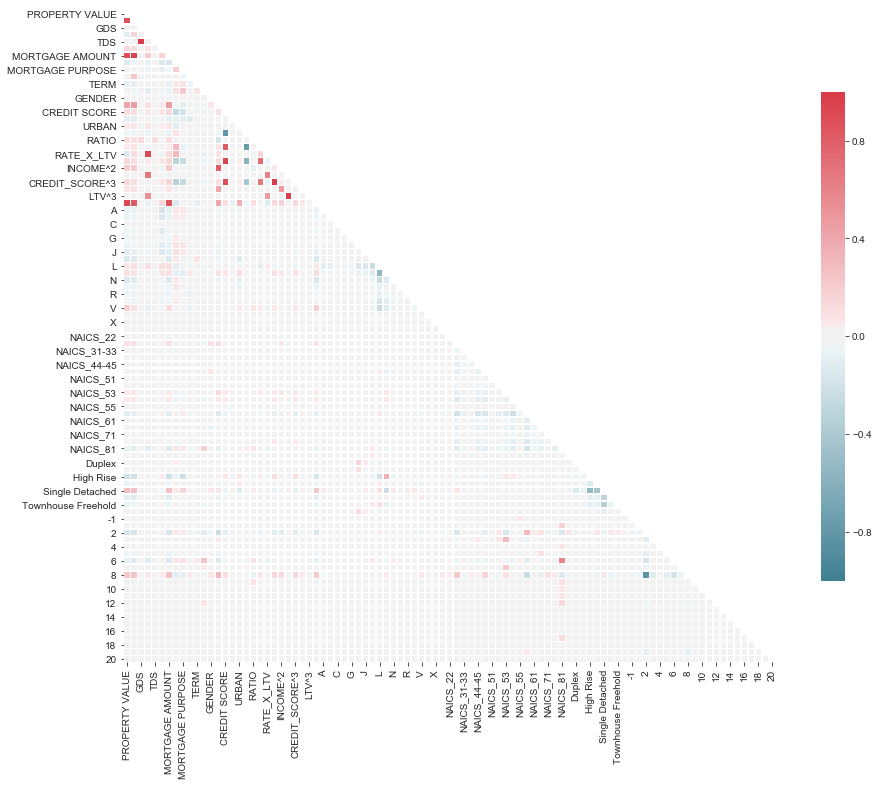

In [713]:
corr = df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .75});

## BASELINE DUMMY CLASSIFIER

In [714]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, roc_curve, roc_auc_score

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import PolynomialFeatures

In [715]:
def dummy_classifier(df):
    
    y = df['RESULT']
    X = df.drop(['RESULT'], axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

    dummy_classifier = DummyClassifier(strategy="most_frequent")
    dummy_classifier.fit( X,y )
    
    print('Dummy Accuracy score: ', accuracy_score(y_test, dummy_classifier.predict(X_test)))
    print('Dummy Precision score: ', precision_score(y_test, dummy_classifier.predict(X_test)))
    print('Dummy Recall score: ', recall_score(y_test, dummy_classifier.predict(X_test)))
    print('Dummy AUC score: ', roc_auc_score(y_test, dummy_classifier.predict(X_test)))
    print('Dummy F1 score: ', f1_score(y_test, dummy_classifier.predict(X_test)))
        
dummy_classifier(df)

Dummy Accuracy score:  0.7916358253145818
Dummy Precision score:  0.7916358253145818
Dummy Recall score:  1.0
Dummy AUC score:  0.5
Dummy F1 score:  0.8837017145217929


## BASELINE LOGISTIC REGRESSION

In [716]:
def prepare_data(df):
    
    #Separate Target & Feature
    y = df['RESULT']
    features = df.drop(['RESULT'], axis=1)
    
    #Test Train Split
    X_train, X_test, y_train, y_test = train_test_split(features, y, random_state=17, test_size = 0.2)
    
    #Scale Data
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(data = scaler.transform(X_train), columns=features.columns)
    X_test = pd.DataFrame(data = scaler.transform(X_test), columns=features.columns)
    
    return X_train, X_test, y_train, y_test, y, features

X_train, X_test, y_train, y_test, y, features = prepare_data(df)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  del sys.path[0]
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  


In [717]:
# def poly_data(features, y):

#     poly = PolynomialFeatures(degree=3, include_bias=False,)
#     poly.fit(features)
#     column_names = poly.get_feature_names(features.columns)
#     df_poly = pd.DataFrame(poly.transform(features), columns=column_names)

#     poly_X_train, poly_X_test, poly_y_train, poly_y_test = train_test_split(df_poly, y, random_state=34,test_size=0.2)
    
#     return poly_X_train, poly_X_test, poly_y_train, poly_y_test
    
# poly_X_train, poly_X_test, poly_y_train, poly_y_test = poly_data(features, y)

## No Adjustment for Imbalance

In [718]:
def baseline_logreg(X_train, X_test, y_train, y_test):

    logreg = LogisticRegression(solver='liblinear')
    logreg.fit(X_train, y_train)
    reg_predict = logreg.predict(X_test)

    print('Train Accuracy score: ', accuracy_score(y_train, logreg.predict(X_train)))
    print('Test Accuracy score: ', accuracy_score(y_test, reg_predict),'\n')
    print('Train F1 score: ', f1_score(y_train, logreg.predict(X_train)))
    print('Test F1 score: ', f1_score(y_test, reg_predict), '\n')
    print("Testing Precision Score: ", precision_score(y_test, reg_predict))
    print("Testing Recall Score: ", recall_score(y_test, reg_predict))
    
    return reg_predict, logreg

reg_predict, logreg = baseline_logreg(X_train, X_test, y_train, y_test)

Train Accuracy score:  0.7881039817251251
Test Accuracy score:  0.7894980337728429 

Train F1 score:  0.8798333934603654
Test F1 score:  0.8810923820723899 

Testing Precision Score:  0.796574128765505
Testing Recall Score:  0.985674608975296


In [719]:
print('Target Funded: ', (y_test == 1).sum())
print('Target Not Funded: ', (y_test ==0).sum())
print('Modeled Funded: ', (reg_predict == 1).sum())
print('Modeled Not Funded: ', (reg_predict == 0).sum())

Target Funded:  6841
Target Not Funded:  1805
Modeled Funded:  8465
Modeled Not Funded:  181


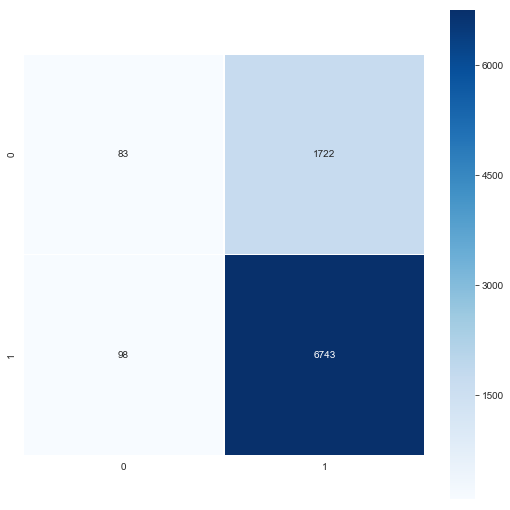

In [720]:
#Baseline Confusion Matrix
cm_lr = confusion_matrix(y_test, reg_predict)
sns.set_style('whitegrid')

plt.figure(figsize = (9, 9))

sns.heatmap(cm_lr, annot = True, fmt = 'g', linewidths = .5, square = True, cmap = "Blues");

AUC:  0.6834168758435067


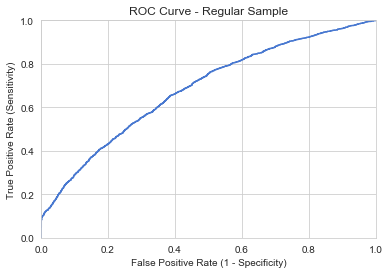

In [721]:
#Baseline ROC Curve
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC Curve - Regular Sample')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print('AUC: ', roc_auc_score(y_test, y_pred_prob));

In [722]:
model_params = list(zip(df.columns, logreg.coef_[0]))

model_params.sort(key = lambda x: abs(x[1]), reverse=True)
model_params

[('PAYMENT FREQUENCY', -1.714243213993313),
 ('MORTGAGE PAYMENT', 1.1245655785271986),
 ('LTV^2', -1.1027173467185485),
 ('MORTGAGE AMOUNT', -0.9309424469055668),
 ('RATE_X_LTV', 0.7453195144605808),
 ('PROPERTY VALUE', -0.6046112361216998),
 ('CREDIT SCORE', 0.468615027377623),
 ('INCOME^2', 0.4397837729035793),
 ('RATE_X_CREDIT_SCORE', -0.4269719785201078),
 ('CREDIT_SCORE^2', 0.32754599124920625),
 ('GDS', 0.2906188687986062),
 ('URBAN', 0.2852421757196713),
 ('MORTGAGE PURPOSE', -0.26430179140091536),
 ('CREDIT_SCORE^3', -0.24616584832013763),
 ('LTV', 0.17157175791385063),
 ('W', -0.14440073223782693),
 (5, 0.13389106902326853),
 ('L', 0.12455905030318389),
 ('NAICS_72', -0.12072712476316334),
 ('LTV^3', 0.12036123633915903),
 ('NAICS_54', -0.11744826245049042),
 ('RATE', -0.10517088577527815),
 ('J', -0.10030967387926541),
 (-1, 0.08443024747358036),
 ('INCOME', -0.07258493971365026),
 (1, -0.07017053597864019),
 ('TDS', 0.06575599521783637),
 ('H', -0.06421013923300257),
 ('G', 

## SMOTE Over Sample

In [723]:
def smote_logreg(X_train, X_test, y_train, y_test):
    
    sm = SMOTE(random_state=23, ratio=1.0)
    X_train_smote, y_train_smote = sm.fit_sample(X_train, y_train)
    
    smote_lr = LogisticRegression(solver='liblinear')
    smote_lr.fit(X_train_smote, y_train_smote)
    smote_pred = smote_lr.predict(X_test)
    
    print('Train Accuracy score: ', accuracy_score(y_train_smote, smote_lr.predict(X_train_smote)))
    print('Test Accuracy score: ', accuracy_score(y_test, smote_pred),'\n')
    print('Train F1 score: ', f1_score(y_train_smote, smote_lr.predict(X_train_smote)))
    print('Test F1 score: ', f1_score(y_test, smote_pred))
    
    return smote_pred, smote_lr, X_train_smote, y_train_smote

smote_pred, smote_lr, X_train_smote, y_train_smote = smote_logreg(X_train, X_test, y_train, y_test)

Train Accuracy score:  0.6372083609332451
Test Accuracy score:  0.628498727735369 

Train F1 score:  0.6327142670864147
Test F1 score:  0.7275195113674924


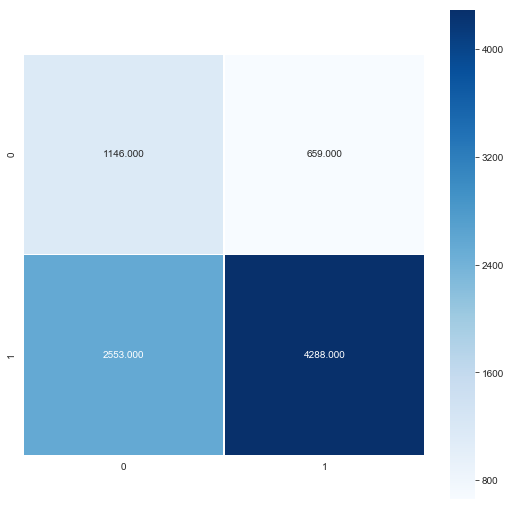

In [724]:
#SMOTE Confusion Matrix
cm_lr = confusion_matrix(y_test, smote_pred)
sns.set_style('whitegrid')

plt.figure(figsize = (9, 9))

sns.heatmap(cm_lr, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "Blues");

AUC:  0.6832419488006363


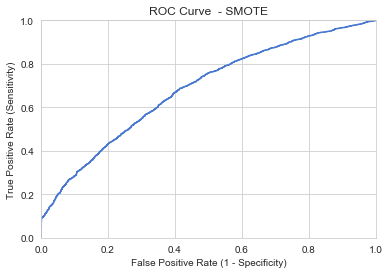

In [725]:
#SMOTE ROC Curve
smote_pred_prob = smote_lr.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, smote_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC Curve  - SMOTE')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print('AUC: ', roc_auc_score(y_test, smote_pred_prob));

## Random Under Sample

In [726]:
def under_sample(X_train, X_test, y_train, y_test):
    
    rus = RandomUnderSampler(random_state=0)
    X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
    
    rus_lr = LogisticRegression(solver='liblinear')
    rus_lr.fit(X_train_rus, y_train_rus)
    rus_pred = rus_lr.predict(X_test)

    print('Train Accuracy score: ', accuracy_score(y_train, rus_lr.predict(X_train)))
    print('Test Accuracy score: ', accuracy_score(y_test, rus_pred),'\n')
    print('Train F1 score: ', f1_score(y_train, rus_lr.predict(X_train)))
    print('Test F1 score: ', f1_score(y_test, rus_pred))
    
    return rus_pred, rus_lr, X_train_rus, y_train_rus

rus_pred, rus_lr, X_train_rus, y_train_rus = under_sample(X_train, X_test, y_train, y_test)

Train Accuracy score:  0.6279964144232716
Test Accuracy score:  0.6294240111034004 

Train F1 score:  0.725675416337932
Test F1 score:  0.7285665875974248


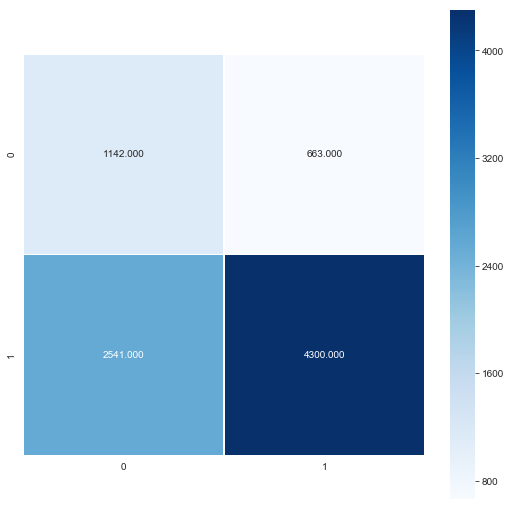

In [727]:
#Random Under Sampling Confusion Matrix
cm_lr = confusion_matrix(y_test, rus_pred)
sns.set_style('whitegrid')

plt.figure(figsize = (9, 9))

sns.heatmap(cm_lr, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "Blues");

AUC:  0.6827457552859753


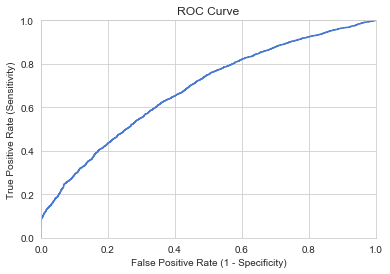

In [728]:
#Random Under Sampling ROC Curve
rus_pred_prob = rus_lr.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, rus_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC Curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print('AUC: ', roc_auc_score(y_test, rus_pred_prob));

In [729]:
# Drop Mortgage Payment
#df = df.drop(['MORTGAGE PAYMENT'], axis=1)

In [730]:
file = pd.read_csv('CAX_MortgageModeling_Test.csv')
submission = pd.read_csv('CAX_MortgageModeling_SubmissionFormat.csv')

test_df = pd.DataFrame(file)
submission_df = pd.DataFrame(submission)

test_df = test_df.drop(['RESULT'], axis=1)

In [731]:
# def encode_test(df):
    
#     # Encode Age Range
#     le_age_range = LabelEncoder()
#     df['AGE RANGE'] = le_age_range.fit_transform(df['AGE RANGE'])
#     df['AGE RANGE'] = df['AGE RANGE'].apply(lambda x: x + 1)
#     df['AGE RANGE'] = df['AGE RANGE'].replace({11:0})
    
#     #Encode Amortization
#     le_amortization = LabelEncoder()
#     df['AMORTIZATION'] = le_amortization.fit_transform(df['AMORTIZATION'])
    
#     #Encode Mortgage Purpose
#     le_purpose = LabelEncoder()
#     df['MORTGAGE PURPOSE'] = le_purpose.fit_transform(df['MORTGAGE PURPOSE'])
    
#     #Encode Payment Frequency
#     le_frequency = LabelEncoder()
#     df['PAYMENT FREQUENCY'] = le_frequency.fit_transform(df['PAYMENT FREQUENCY'])
    
#     #Encode Gender
#     le_gender = LabelEncoder()
#     df['GENDER'] = le_gender.fit_transform(df['GENDER'])
    
#     #NAICS Dummy Variables
#     #df_temp = pd.get_dummies(df['NAICS CODE'], prefix='NAICS', drop_first=True)
#     #df = pd.concat([df, df_temp], axis=1)
#     df.drop(['NAICS CODE'], axis=1, inplace=True)
    
#     #Property Type Dummy Variables
#     df_temp = pd.get_dummies(df['PROPERTY TYPE'], drop_first=True)
#     df = pd.concat([df, df_temp], axis=1)
#     df.drop(['PROPERTY TYPE'], axis=1, inplace=True)
    
#     #Encode Territory Dummy Variables
#     le_territory = LabelEncoder()
#     df['TERRITORY'] = le_territory.fit_transform(df['TERRITORY'])
    
#     return df

# test_df = encode_test(clean_data(test_df))

In [732]:
# def run_test(df):
    
#     test_logreg = logreg.predict(df)

#     test_logreg = np.where(test_logreg == 0, 'NOT FUNDED', 'FUNDED')
    
#     return test_logreg
    
# results = pd.DataFrame(run_test(test_df))

In [733]:
# results[0].value_counts()

## Decision Tree

In [742]:
from sklearn.tree import DecisionTreeClassifier

def decision_tree(X_train, X_test, y_train, y_test):
    
    dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth=41, min_samples_leaf=6, min_impurity_decrease=0.0005)
    dt_clf = dt_clf.fit(X_train, y_train)
    
    y_pred_train = dt_clf.predict(X_train)
    decision_tree_pred = dt_clf.predict(X_test)
    
    print("Training F1 Score:", f1_score(y_train, y_pred_train))
    print("Testing F1 Score:", f1_score(y_test, decision_tree_pred))
    print("Testing Precision Score: ", precision_score(y_test, decision_tree_pred))
    print("Testing Recall Score: ", recall_score(y_test, decision_tree_pred))
    print('AUC: ', roc_auc_score(y_test, decision_tree_pred))
    
    return decision_tree_pred, dt_clf

decision_tree_pred, dt_clf = decision_tree(X_train_smote, X_test, y_train_smote, y_test)

Training F1 Score: 0.8010864305449323
Testing F1 Score: 0.863255314868218
Testing Precision Score:  0.7975216852540272
Testing Recall Score:  0.9407981289285192
AUC:  0.5177674855168911


In [743]:
print('Target Funded: ', (y_test == 1).sum())
print('Target Not Funded: ', (y_test ==0).sum())
print('Modeled Funded: ', (decision_tree_pred == 1).sum())
print('Modeled Not Funded: ', (decision_tree_pred == 0).sum())

Target Funded:  6841
Target Not Funded:  1805
Modeled Funded:  8070
Modeled Not Funded:  576


Confusion matrix, without normalization
[[ 171 1634]
 [ 405 6436]]


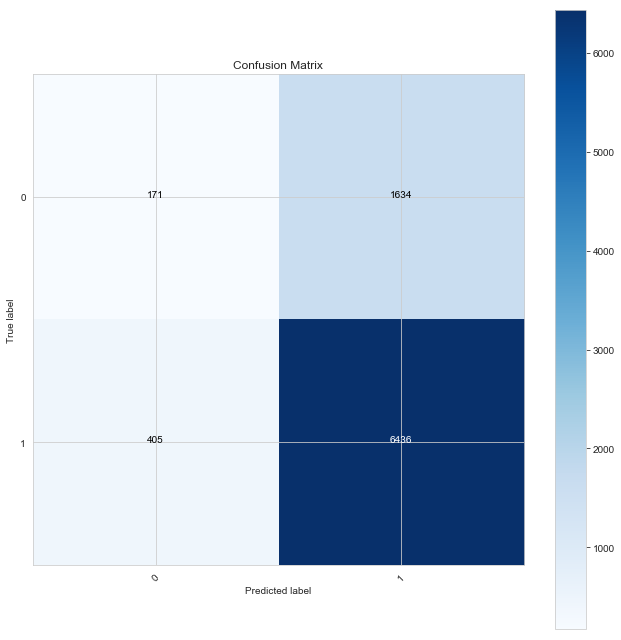

In [744]:
import itertools

class_names = np.unique(decision_tree_pred)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, decision_tree_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(9,9))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion Matrix')

plt.show();

In [745]:
importances.shape

(92,)

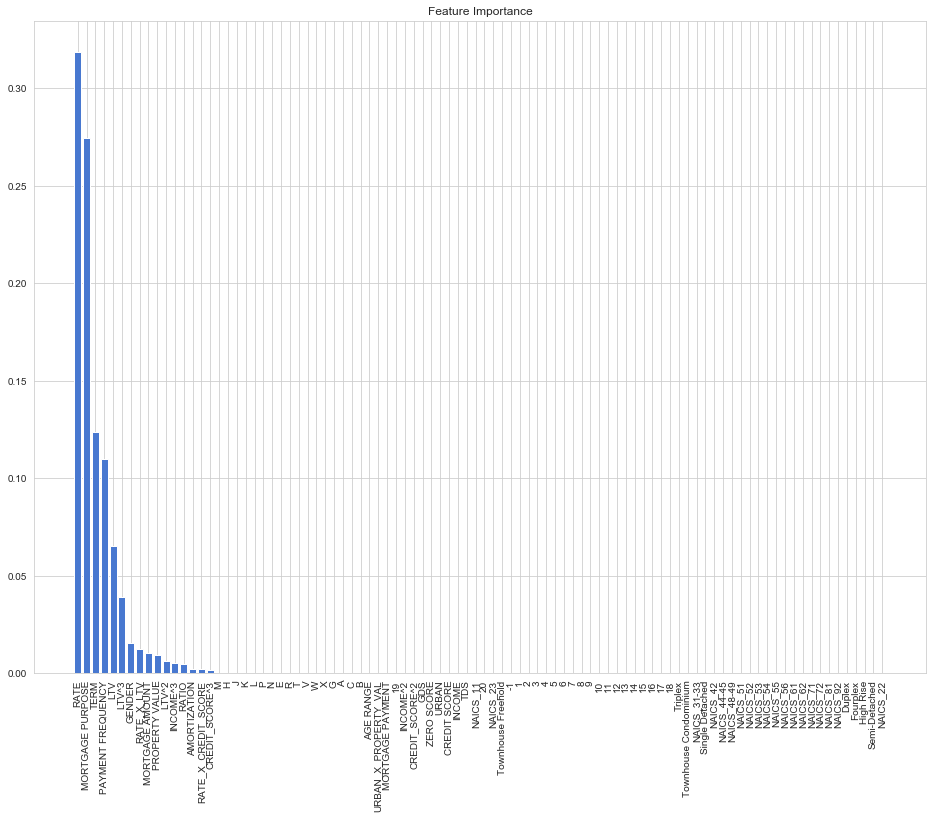

In [746]:
importances = dt_clf.feature_importances_

indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [features.columns[i] for i in indices]

# Create plot
plt.figure(figsize=(16,12))

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(features.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(features.shape[1]), names, rotation=90)

# Show plot
plt.show();

AUC:  0.6047662760097684


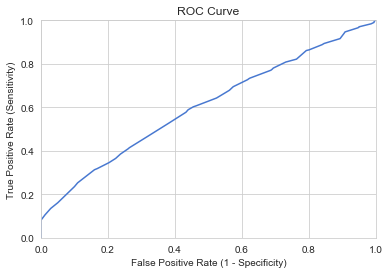

In [747]:
decision_tree_prob = dt_clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, decision_tree_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC Curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print('AUC: ', roc_auc_score(y_test, decision_tree_prob));

In [676]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [677]:
# # Create regularization penalty space
# penalty = ['l1', 'l2']

# # Create regularization hyperparameter space
# C = C_param_range = [0.001, 0.01, 0.1, 0.5, 1, 2, 5, 10,]

# # Create hyperparameter options
# hyperparameters_1 = dict(C=C, penalty=penalty)

In [678]:
# # Create grid search using 5-fold cross validation
# clf_gs = GridSearchCV(dt_clf, hyperparameters, cv=5, scoring='f1')

In [679]:
# model = clf_gs.fit(X_train, y_train)

## Randomized Search - Decision Tree

In [740]:
clf = DecisionTreeClassifier()

param_distributions = {
              'criterion': ['entropy', 'gini'],
              'max_depth': range(3,50, 1), 
              'min_samples_leaf': range(1,25,1),
              'min_impurity_decrease': [0.0005, 0.001, 0.002, 0.003]
             }

randomized_search = RandomizedSearchCV(estimator=clf,cv=5, param_distributions=param_distributions,scoring='f1')
randomized_search = randomized_search.fit(X_train_smote, y_train_smote)

best_clf = randomized_search.best_estimator_

print(randomized_search.best_score_)
print(randomized_search.best_params_)
print(randomized_search.best_estimator_)

0.7993035819515243
{'min_samples_leaf': 6, 'min_impurity_decrease': 0.0005, 'max_depth': 41, 'criterion': 'entropy'}
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=41,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0005, min_impurity_split=None,
            min_samples_leaf=6, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


In [741]:
f1_score(y_test, best_clf.predict(X_test))

0.863255314868218

## Random Forest Classifier

In [617]:
from sklearn.ensemble import RandomForestClassifier

In [751]:
rfc = RandomForestClassifier(n_estimators=250, random_state=17)

rfc.fit(X_train_smote, y_train_smote)
rfc_pred = rfc.predict(X_test)

# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, rfc_pred))
print('Test F1 score: ', f1_score(y_test, rfc_pred))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=None,
            oob_score=False, random_state=17, verbose=0, warm_start=False)

Test Accuracy score:  0.7479759426324312
Test F1 score:  0.8481427277162171


In [752]:
print('Target Funded: ', (y_test == 1).sum())
print('Target Not Funded: ', (y_test ==0).sum())
print('Modeled Funded: ', (rfc_pred == 1).sum())
print('Modeled Not Funded: ', (rfc_pred == 0).sum())

Target Funded:  6841
Target Not Funded:  1805
Modeled Funded:  7508
Modeled Not Funded:  1138


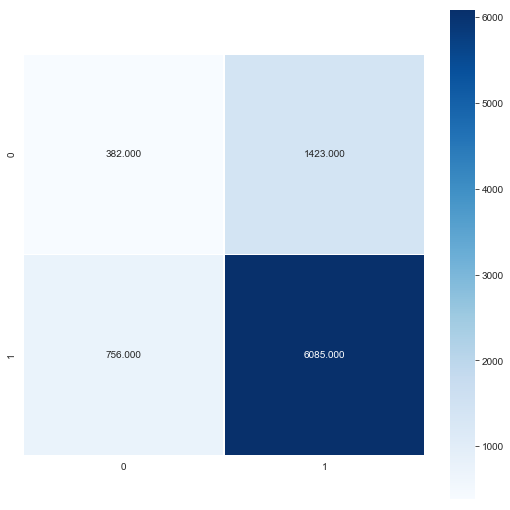

In [753]:
cm_lr = confusion_matrix(y_test, rfc_pred)
sns.set_style('whitegrid')

plt.figure(figsize = (9, 9))

sns.heatmap(cm_lr, annot = True, fmt = ".3f", linewidths = .5, square = True, cmap = "Blues");

## Randomized Search - Random Forest

In [755]:
clf = RandomForestClassifier(criterion='entropy')

param_distributions = {
              'n_estimators': [250, 300, 350,400],
              'max_features': [55, 65, 75, 85, 95]
             }

randomized_search = RandomizedSearchCV(estimator=clf,cv=5, param_distributions=param_distributions,scoring='f1')
randomized_search = randomized_search.fit(X_train_smote, y_train_smote)

best_clf = randomized_search.best_estimator_

print(randomized_search.best_score_)
print(randomized_search.best_params_)
print(randomized_search.best_estimator_)

0.8703969118787812
{'n_estimators': 250, 'max_features': 65, 'criterion': 'entropy'}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=65, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [756]:
f1_score(y_test, randomized_search.predict(X_test))

0.8657663740715731

In [181]:
from numpy import loadtxt
from numpy import sort
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel

In [182]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]= "True"